# FactorVAE Model Testing Framework

In [1]:
from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader

seed = 42
set_deterministic_run(seed=seed)

## 1. Imports

In [2]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## 2. Configuration

In [25]:
# --- General Hyperparameters ---
model_name = 'vae_locatello'  # Name of the model architecture file (e.g., 'vae_burgess')
latent_dim = 10
learning_rate = 1e-4
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rec_dist = 'bernoulli'  # Reconstruction distribution (e.g., 'bernoulli', 'gaussian')

train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 10

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

In [26]:
# --- Loss Specific Hyperparameters ---
# Factor VAE
loss_name = 'factorvae'      # Type of loss
loss_kwargs = {
    'gamma': 20,          # Weight of the TC loss term
    'discr_lr': 5e-5,      # Discriminator learning rate
    'discr_betas': (0.5, 0.9), # Discriminator Adam betas
    'rec_dist': rec_dist,
    'device': device       # Pass device to loss for discriminator
}

## 3. Load Datasets

In [5]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=seed,
                                                   pin_memory=True)

print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")


Loaded 3D Shapes dataset with 480000 samples.


In [6]:
# Load dSprites
Dsprites = get_dataset('dsprites')

dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,
                                                   pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 737280 samples.


## 4. Setup Model, Loss, and Optimizer

In [20]:
def setup_components(dataset, loss_kwargs):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate Model
    model = vae_models.select(name=model_name, img_size=img_size, latent_dim=latent_dim)

    # FactorVAE loss needs the device for its internal discriminator
    current_loss_kwargs = loss_kwargs.copy() # Avoid modifying the global dict
    current_loss_kwargs['device'] = device
    loss_fn = losses.select(loss_name, **current_loss_kwargs)

    # Instantiate VAE Optimizer (Discriminator optimizer is inside the loss)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.__class__.__name__}")
    print(f"Loss: {loss_fn.__class__.__name__} (rec_dist={rec_dist}), kwargs={current_loss_kwargs}")
    print(f"Optimizer (VAE): {optimizer.__class__.__name__}")
    print(f"Optimizer (Disc): Adam (internal to loss)")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## 5. Train and Visualize

## 5.1 - 3D Shapes

In [27]:
# Define loss kwargs specifically for 3D Shapes if needed, otherwise use global
shapes3d_loss_kwargs = loss_kwargs.copy() # Start with global settings
# shapes3d_loss_kwargs['gamma'] = 10 # Example: Override gamma for this dataset

In [28]:
print("\n===== Training on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)

# Use BaseTrainer as FactorVAE loss handles optimization internally
trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                               loss_fn=loss_fn_3dshapes,
                               lr_scheduler=None,
                               optimizer=optimizer_3dshapes,
                               device=device,
                               train_step_unit=train_step_unit,
                               )

train_logs_3dshapes = trainer_3dshapes.train(shapes3d_dataloader, max_steps=num_train_steps)
print("Training Logs (3D Shapes):", train_logs_3dshapes)


===== Training on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'gamma': 20, 'discr_lr': 5e-05, 'discr_betas': (0.5, 0.9), 'rec_dist': 'bernoulli', 'device': device(type='cuda')}
Optimizer (VAE): Adam
Optimizer (Disc): Adam (internal to loss)
---------------------------


Training Logs (3D Shapes): None



===== Visualizing 3D Shapes Results =====
Plotting random reconstructions...


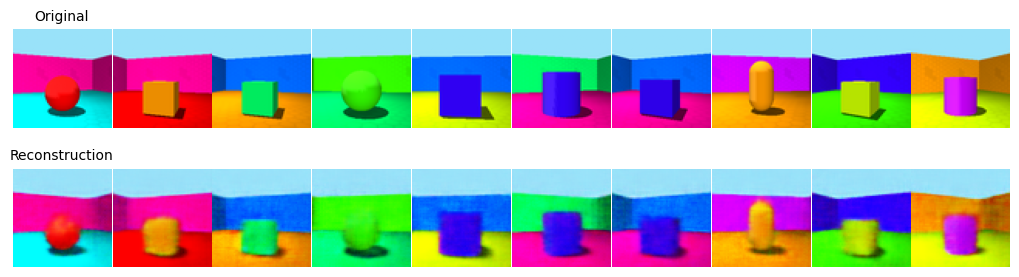

Plotting reconstructions from specific indices...


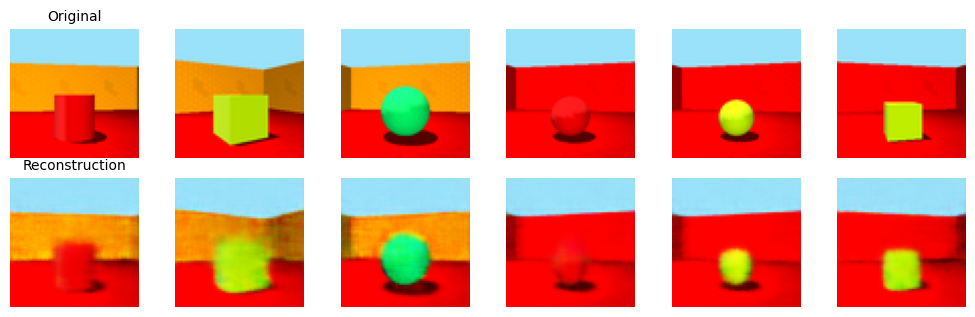

Plotting latent traversals...


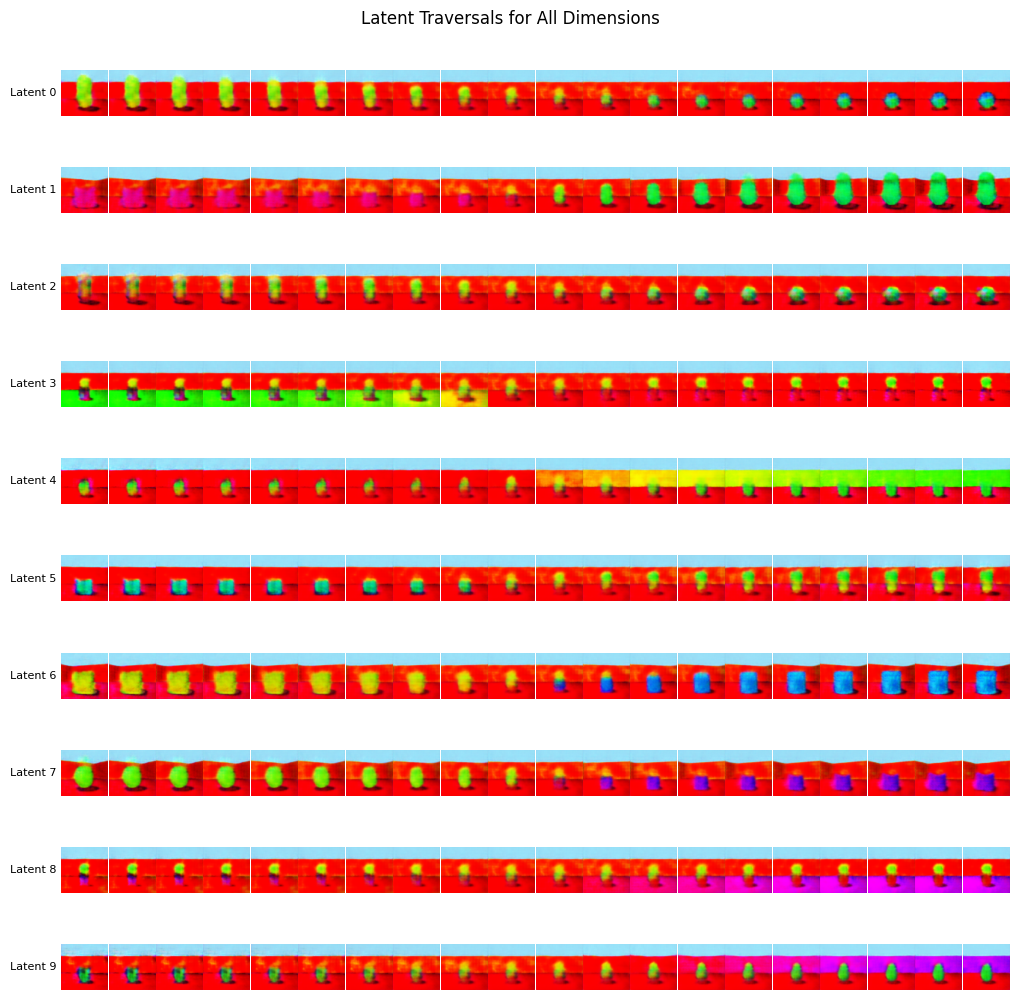

In [29]:
print("\n===== Visualizing 3D Shapes Results =====")
visualizer_3dshapes = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20)
plt.show()

### 5.1.1 Metric Evaluation (3D Shapes)

In [11]:
metrics_to_compute = [
    {'name': 'dci_d', 'args':{'num_train':5000, 'num_test':1000}},
    {'name': 'mig', 'args':{}}
]

In [12]:
metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

In [13]:
print("\n===== Computing Metrics for 3D Shapes =====")
metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes, 
                                                              data_loader=shapes3d_dataloader, 
                                                              device=device)
print("3D Shapes Metrics:", metrics_results_3dshapes)


===== Computing Metrics for 3D Shapes =====


Computing representations: 100%|██████████| 7500/7500 [00:23<00:00, 313.90it/s]


3D Shapes Metrics: {'dci_d': {'informativeness_train_errors': 0.10303333333333332, 'informativeness_test_errors': 0.331, 'informativeness_train_scores': 0.8969666666666667, 'informativeness_test_scores': 0.669, 'disentanglement': 0.19159617900250323, 'completeness': 0.15775118744501396}, 'mig': 0.07061903228564036}


## 5.2. Train and Visualize: dSprites

In [14]:
# Define loss kwargs specifically for dSprites if needed, otherwise use global
dsprites_loss_kwargs = loss_kwargs.copy() # Start with global settings
# dsprites_loss_kwargs['gamma'] = 10 # Example: Override gamma for this dataset

In [15]:
print("\n===== Training on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, dsprites_loss_kwargs)

# Use BaseTrainer as FactorVAE loss handles optimization internally
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                               loss_fn=loss_fn_dsprites,
                               lr_scheduler=None,
                               optimizer=optimizer_dsprites,
                               device=device,
                               train_step_unit=train_step_unit,
                               return_log_loss=True, # Get logs back
                               log_loss_interval_type='epoch' # Log per epoch
                               )

train_logs_dsprites = trainer_dsprites.train(dsprites_dataloader, max_steps=num_train_steps)
print("Training Logs (dSprites):", train_logs_dsprites)


===== Training on dSprites =====
--- Setup for DSprites --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'gamma': 6.4, 'discr_lr': 5e-05, 'discr_betas': (0.5, 0.9), 'rec_dist': 'bernoulli', 'device': device(type='cuda')}
Optimizer (VAE): Adam
Optimizer (Disc): Adam (internal to loss)
---------------------------


Training Logs (dSprites): [{'rec_loss': 104.082839099235, 'kl_loss': 19.150487045902345, 'loss': 130.07856419152682, 'tc_loss': 1.0695684213810535, 'discrim_loss': 0.4674023286297193, 'epoch': 1}, {'rec_loss': 60.02526962194178, 'kl_loss': 21.600404852297572, 'loss': 88.60095096760325, 'tc_loss': 1.0898869516327978, 'discrim_loss': 0.4563907317700796, 'epoch': 2}, {'rec_loss': 49.31707068251239, 'kl_loss': 23.29648504704237, 'loss': 80.78159291611777, 'tc_loss': 1.2762558052368047, 'discrim_loss': 0.4325383651820529, 'epoch': 3}, {'rec_loss': 46.15529848900106, 'kl_loss': 23.34976866112815, 'loss': 77.92492236296336, 'tc_loss': 1.3156023701238964, 'discrim_loss': 0.4335189015501075, 'epoch': 4}, {'rec_loss': 44.63581101033423, 'kl_loss': 23.38678544047806, 'loss': 76.49173468748728, 'tc_loss': 1.3233028496331019, 'discrim_loss': 0.43708958668867126, 'epoch': 5}]



===== Visualizing dSprites Results =====
Plotting random reconstructions...


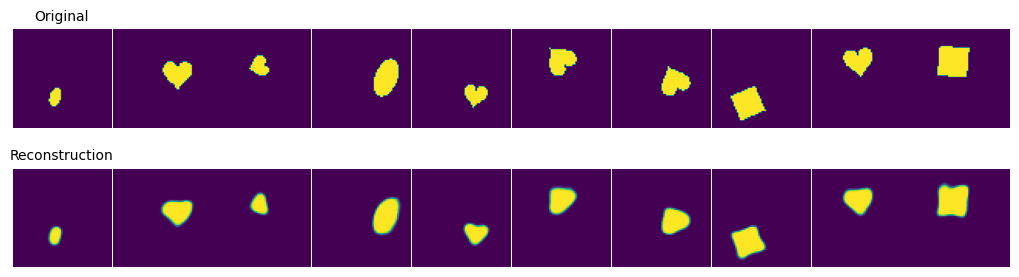

Plotting reconstructions from specific indices...


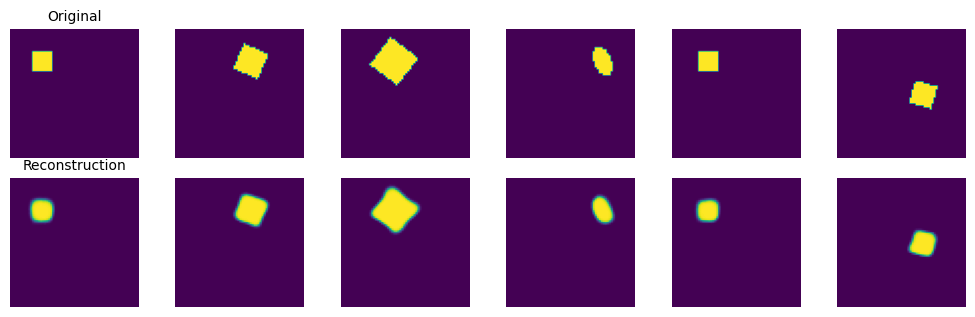

Plotting latent traversals...


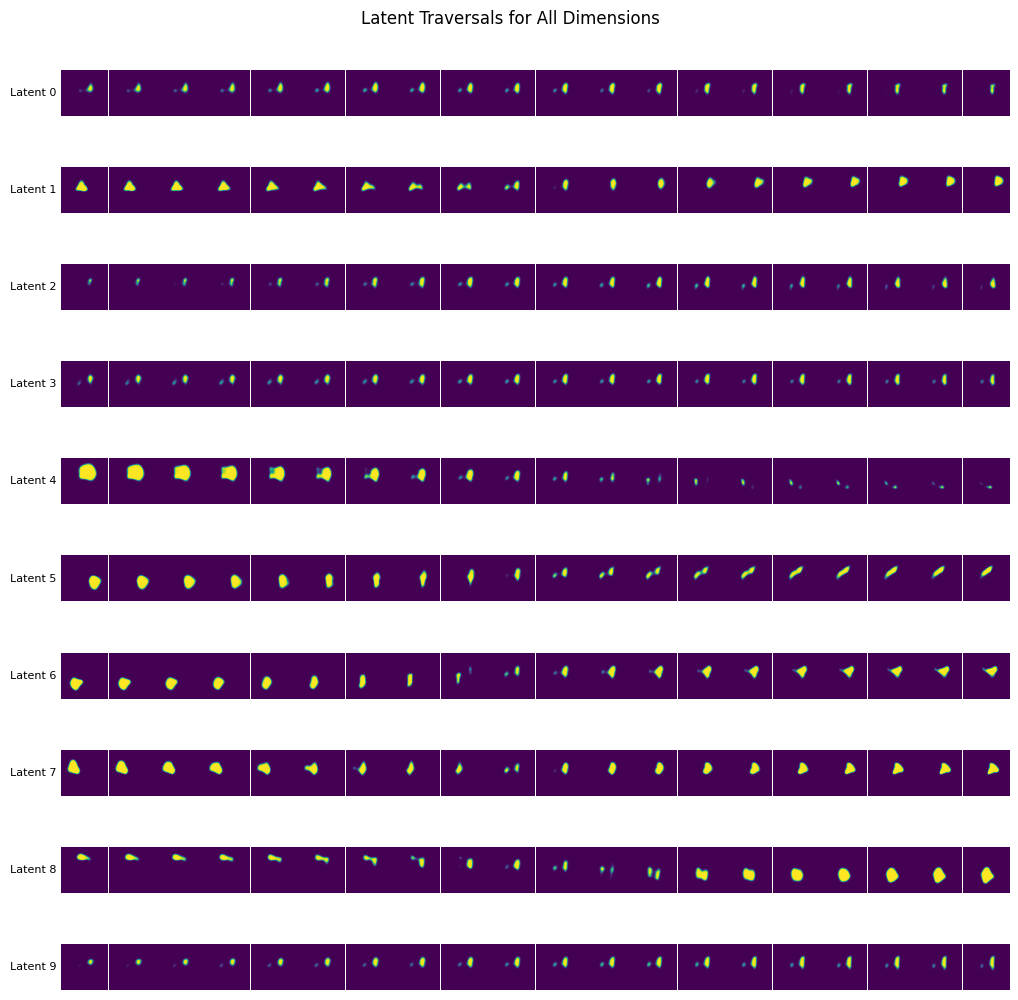

In [16]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.Visualizer(vae_model=model_dsprites, dataset=dsprites_dataset)

print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 100000, 200000, 300000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20)
plt.show()

### 5.2.1 Metric Evaluation (dSprites)

In [17]:
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

In [18]:
print("\n===== Computing Metrics for dSprites =====")
metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
                                                            data_loader=dsprites_dataloader, 
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)


===== Computing Metrics for dSprites =====


Computing representations: 100%|██████████| 11520/11520 [00:23<00:00, 485.54it/s]


dSprites Metrics: {'dci_d': {'informativeness_train_errors': 0.17184000000000002, 'informativeness_test_errors': 0.6678000000000001, 'informativeness_train_scores': 0.8281600000000001, 'informativeness_test_scores': 0.33219999999999994, 'disentanglement': 0.07650040309608194, 'completeness': 0.09730908661776841}, 'mig': 0.05337066601226825}
